In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
pd.options.display.max_columns= 100


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

In [2]:
# !wget https://github.com/IBM/employee-attrition-aif360/raw/master/data/emp_attrition.csv --output-document=emp_attrition.csv

In [3]:
df = pd.read_csv('attrition_final.csv')
df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)
df["Attrition"] = df['Attrition'].map({"Yes":1, "No":0})

In [4]:
categorical_cols = ['BusinessTravel', 'Department', 'Education', 'EducationField',
'Gender', 'JobRole', 'MaritalStatus','OverTime']
ordinal_cols = ['JobInvolvement','JobLevel','JobSatisfaction','PerformanceRating','RelationshipSatisfaction',
'WorkLifeBalance', 'EnvironmentSatisfaction']
numerical_cols = ['Age', 
# 'DailyRate',
'DistanceFromHome', 
# 'HourlyRate',
'MonthlyIncome', 
# 'MonthlyRate',
 'NumCompaniesWorked','StockOptionLevel','TotalWorkingYears', 
'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager','PercentSalaryHike']

In [5]:
# np.setdiff1d(df.columns.to_list(), categorical_cols + ordinal_cols+ numerical_cols)

In [6]:
ohe = OneHotEncoder(drop_last=False)
ordinal_enc = OrdinalEncoder()

cat_data = ohe.fit_transform(df[categorical_cols])
ord_data = ordinal_enc.fit_transform(df[ordinal_cols], df['Attrition'])

In [7]:
# feature_correlation = data.drop('Attrition', axis=1).corrwith(data.Attrition).sort_values()
# model_col = feature_correlation[np.abs(feature_correlation) > 0.02].index
# len(model_col)

In [8]:
cat_data.shape, ord_data.shape, df[numerical_cols].shape

((1470, 33), (1470, 7), (1470, 12))

In [9]:
scaler = StandardScaler()
num_data = pd.DataFrame(scaler.fit_transform(df[numerical_cols]), columns=numerical_cols)

In [10]:
data = pd.concat([cat_data, ord_data, num_data, df['Attrition']], axis=1)

In [11]:
X = data.drop('Attrition', axis=1)
y = data.Attrition

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42,
                                                    stratify=y)

In [13]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.839002
 1    0.160998
 Name: Attrition, dtype: float64,
 0    0.836735
 1    0.163265
 Name: Attrition, dtype: float64)

In [14]:
X_train.shape, X_test.shape

((1323, 52), (147, 52))

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, 
random_state=2024, stratify=y_train)

In [21]:
import optuna

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(xtrain, ytrain, xval, yval):
    model = LogisticRegression(class_weight='balanced', max_iter=500, random_state=2024)
    model.fit(xtrain, ytrain)
    preds= model.predict(xval)
    print(roc_auc_score(yval, preds))
    print(classification_report(yval, preds))
    print(confusion_matrix(yval, preds))

    return model

In [20]:
model = evaluate_model(X_train, y_train, X_val, y_val)

0.8017548798798798
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       333
           1       0.40      0.84      0.55        64

    accuracy                           0.77       397
   macro avg       0.68      0.80      0.70       397
weighted avg       0.87      0.77      0.80       397

[[253  80]
 [ 10  54]]


In [18]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       123
           1       0.35      0.67      0.46        24

    accuracy                           0.74       147
   macro avg       0.63      0.71      0.64       147
weighted avg       0.83      0.74      0.77       147

[[93 30]
 [ 8 16]]


In [31]:
imp_df = pd.DataFrame(model.coef_[0], index=X_train.columns, columns=['Score'])

In [44]:
imp_df.sort_values(by='Score',ascending=False, inplace=True)

In [46]:

fig = px.bar(imp_df.head(20), x = 'Score')
fig.update_layout(yaxis={'categoryorder':'total ascending'})

In [51]:
pd.DataFrame(classification_report(y_test, predictions, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.920792,0.347826,0.741497,0.634309,0.827247
recall,0.756098,0.666667,0.741497,0.711382,0.741497
f1-score,0.830357,0.457143,0.741497,0.643750,0.769424
support,123.000000,24.000000,0.741497,147.000000,147.000000


In [174]:
import lightgbm as lgb

In [201]:
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
lgb_valid = lgb.Dataset(X_val, y_val, free_raw_data=False)

In [217]:
params = {    
    'objective': 'binary',
    # 'metric' : 'auc',
    'num_leaves': 343,
    'max_depth': 11,
    'min_child_weight': 7,
    'feature_fraction': 0.7259751026557617,
    'bagging_fraction': 0.7219404824164256,
    'bagging_freq': 3,
    'min_child_samples': 50,
    'lambda_l1': 0.00018060247973033773,
    'lambda_l2': 0.010861117919906805,
    'learning_rate': 0.10757089100621464,
    'max_bin': 728
}

In [218]:
model = lgb.train(
                    params, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_valid],
                    verbose_eval=10,
                    num_boost_round=100,
                    early_stopping_rounds=10
                )

/home/pr/.virtualenvs/stream/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

/home/pr/.virtualenvs/stream/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 149, number of negative: 777
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 628
[LightGBM] [Info] Number of data points in the train set: 926, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160907 -> initscore=-1.651494
[LightGBM] [Info] Start training from score -1.651494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

auc: 0.8849474474474475


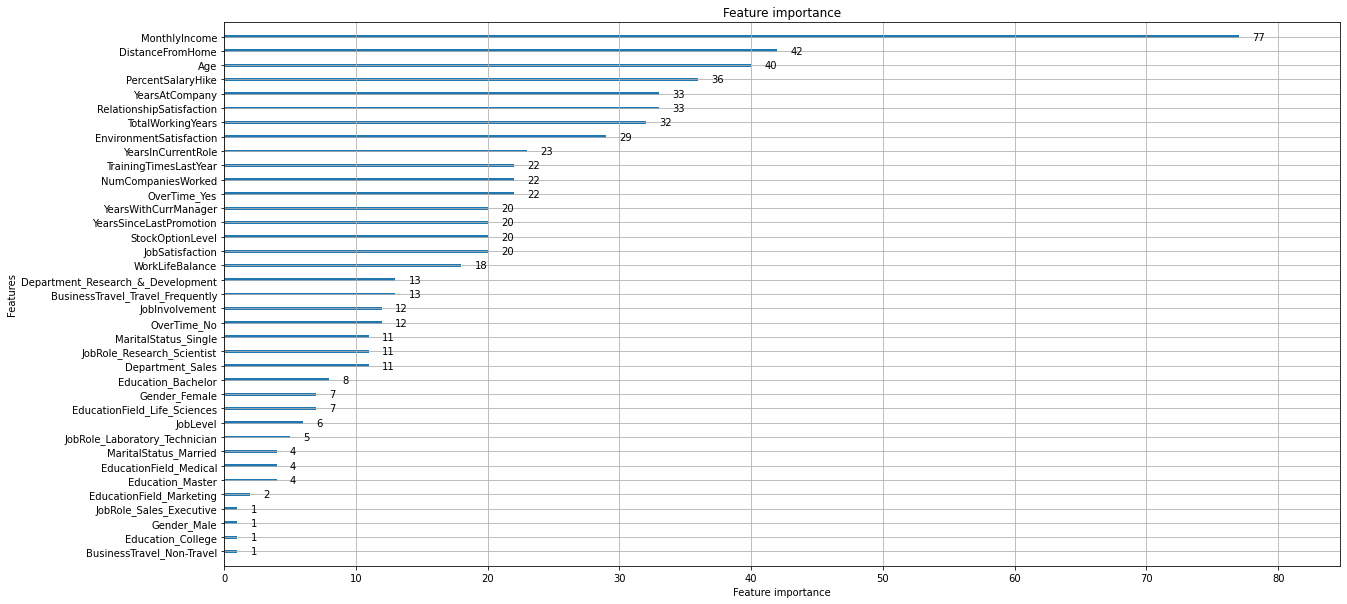

In [219]:
print('auc:', roc_auc_score(y_val, model.predict(X_val)))
_ = lgb.plot_importance(model, figsize=(20, 10))

In [216]:
# model.predict(X_val)

In [220]:
print(classification_report(y_val, np.round(model.predict(X_val), 0)))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       333
           1       0.72      0.45      0.56        64

    accuracy                           0.88       397
   macro avg       0.81      0.71      0.75       397
weighted avg       0.87      0.88      0.87       397



In [221]:
confusion_matrix(y_val, np.round(model.predict(X_val), 0))

array([[322,  11],
       [ 35,  29]])

In [196]:
imp_df = pd.DataFrame(model.feature_importance(), index=X_train.columns, columns=['Score'])
imp_df.sort_values(by='Score', ascending=True, inplace=True)

In [198]:
px.bar(imp_df.tail(20), x='Score').update_xaxes(categoryorder = 'total descending')

In [85]:
from joblib import dump, load

dump(log_opt, 'logistic_regression_final.joblib') 

['logistic_regression_final.joblib']

In [86]:
clf = load('logistic_regression_final.joblib') 

In [90]:
# clf.predict_proba(X_test)[:, 1]

In [ ]:
# col = df.select_dtypes(include='object').columns.to_list()

# for i in col:
#     print(f"{i} = st.selectbox('{i}', df['{i}'].unique())")

In [ ]:
for i in col:
    print(f"'{i}':", i ,",")

In [ ]:
col = df.select_dtypes(include='int').columns.to_list()

for i in col:
    print(f"{i} = st.number_input('{i}', min_value= 0, max_value=100)")

    # st.number_input('Num', min_value= 0, max_value=80)


In [ ]:
for i in col:
    print(f"'{i}':", i ,",")